In [1]:
import numpy as np
import mujoco
import os
from ament_index_python.packages import get_package_share_directory

from mjx_planner import cem_planner
from quat_math import quaternion_distance, quaternion_multiply, rotation_quaternion
# from sampling_based_planner.Simple_MLP.mlp_singledof import MLP, MLPProjectionFilter


In [2]:
# model_path = os.path.join(get_package_share_directory('real_demo'), 'panda_mjx', 'franka_emika_panda', 'panda_scene.xml')

print(os.getcwd())


/home/alinjar/colcon_ws/src/manipulator_mujoco/real_demo/sampling_based_planner


In [3]:
# model_path = "../panda_mjx/franka_emika_panda/panda_scene.xml"
model_path = "../ur5e_hande_mjx/scene.xml"
num_dof = 12
num_batch = 20
num_steps = 15
maxiter_cem = 1
num_elite = 0.5
timestep = 0.1
maxiter_projection = 5
max_joint_pos = 180.0*np.pi/180.0
max_joint_vel=1.0
max_joint_acc = 2.0
max_joint_jerk=4.0
w_pos = 1.0
w_rot = 1.0
w_col = 1.0


model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)
cem = cem_planner(
            model=model,
            num_dof=num_dof, 
            num_batch=num_batch, 
            num_steps=num_steps, 
            maxiter_cem=maxiter_cem,
            num_elite=num_elite,
            timestep=timestep,
            maxiter_projection=maxiter_projection,
            max_joint_pos=max_joint_pos,
            max_joint_vel=max_joint_vel,
            max_joint_acc=max_joint_acc,
            max_joint_jerk=max_joint_jerk,

        )


Found geom: id=7, name='robot_1'
Found geom: id=12, name='robot_2'
Found geom: id=13, name='robot_3'
Found geom: id=18, name='robot_4'
Found geom: id=19, name='robot_5'
Found geom: id=23, name='robot_6'
Found geom: id=27, name='robot_7'
Found geom: id=28, name='robot_8'
Found geom: id=32, name='robot_0'
Found geom: id=34, name='robot_01'
Found geom: id=36, name='robot_02'
Found geom: id=43, name='robot_11'
Found geom: id=48, name='robot_12'
Found geom: id=49, name='robot_13'
Found geom: id=54, name='robot_14'
Found geom: id=55, name='robot_15'
Found geom: id=59, name='robot_16'
Found geom: id=63, name='robot_17'
Found geom: id=64, name='robot_18'
Found geom: id=67, name='robot_10'
Found geom: id=70, name='robot_101'
Found geom: id=74, name='robot_103'
Found geom: id=78, name='robot_102'
Found geom: id=82, name='robot_104'
(144,)
(15, 144)

 Default backend: gpu
 Timestep: 0.1 
 CEM Iter: 1 
 Projection Iter: 5 
 Number of batches: 20 
 Number of steps per trajectory: 15 
 Time per traj

In [4]:
# import jax
# def compute_xi_samples(self, key, xi_mean, xi_cov ):
#     key, subkey = jax.random.split(key)
#     xi_samples = jax.random.multivariate_normal(key, xi_mean, xi_cov+0.003*jnp.identity(self.nvar), (self.num_batch, ))
#     return xi_samples, key

import jax
import jax.numpy as jnp

In [6]:
# print(cem.timestep)

In [7]:
xi_mean_single = jnp.zeros(cem.nvar_single)
xi_cov_single = 1.0*jnp.identity(cem.nvar_single)
xi_mean = jnp.tile(xi_mean_single, cem.num_dof)
xi_cov = jnp.kron(jnp.eye(cem.num_dof), xi_cov_single)
key = jax.random.PRNGKey(42)
xi_samples, _ = cem.compute_xi_samples(key, xi_mean, xi_cov)

# init_pos = jnp.array([0.0, -0.3, 0.0, -2.0, 0.0, 1.7,
#                       0.0, -0.3, 0.0, -2.0, 0.0, 1.7])

init_pos = jnp.array([1.5, -1.8, 1.75, -1.25, -1.6, 0, -1.5, -1.8, 1.75, -1.25, -1.6, 0])

init_vel = jnp.array([0.1, 0.2, 0.05, -0.05, 0.01, 0.05,
                      0.0, 0.1, 0.04, 0.07, 0.03, 0.1])

init_acc = jnp.zeros_like(init_pos)


In [8]:
target_pos_0 = data.xpos[model.body(name="target_0").id]
target_rot_0 = data.xquat[model.body(name="target_0").id].copy()
target_0 = np.concatenate([target_pos_0, target_rot_0])

target_pos_2 = data.xpos[model.body(name="ball").id]
target_rot_2 = data.xquat[model.body(name="ball").id].copy()
target_2 = np.concatenate([target_pos_2, target_rot_2])

ball_pick_init = target_2

# Get obstacle reference
obstacle_pos = data.mocap_pos[model.body_mocapid[model.body(name='obstacle').id]]
obstacle_rot = data.mocap_quat[model.body_mocapid[model.body(name='obstacle').id]]

# def update_targets(self, target_idx=0, target_pos=None, target_rot=None):
#     """Update target positions and rotations for both arms"""
#     if target_idx==0:
#         self.target_pos_0 = target_pos
#         self.target_rot_0 = target_rot
#         self.target_0 = np.concatenate([self.target_pos_0, self.target_rot_0])
#     elif target_idx==1:
#         self.target_pos_1 = target_pos
#         self.target_rot_1 = target_rot
#         self.target_1 = np.concatenate([self.target_pos_1, self.target_rot_1])
    
# def update_obstacle(self, obstacle_pos, obstacle_rot):
#     """Update obstacle position and rotation"""
#     self.obstacle_pos = obstacle_pos
#     self.obstacle_rot = obstacle_rot


In [9]:


lamda_init = jnp.zeros((num_batch, cem.nvar))
s_init = jnp.zeros((num_batch, cem.num_total_constraints))

cost_weights = {
    'collision': 500,
    'theta': 0.3,
    'z-axis': 10.0,
    'velocity': 0.1,
    'distance': 7.0,

    'allign': 2.0,
    'orientation': 7.0,
    'eef_to_obj': 10.0,
    'obj_to_targ': 1.0,

    'pick': 0,
    'move': 0
}



In [10]:
# opt_class = cem_planner(num_dof=num_dof, num_batch=num_batch, num_steps=num_steps, maxiter_cem=maxiter_cem,
#                         w_pos=w_pos, w_rot=w_rot, w_col=w_col, num_elite=num_elite, timestep=timestep,
#                         maxiter_projection=maxiter_projection,
#                         max_joint_pos = max_joint_pos, max_joint_vel=max_joint_vel, max_joint_acc=max_joint_acc, 
#                         max_joint_jerk=max_joint_jerk)

opt_class = cem_planner(model=model, num_dof=num_dof, num_batch=num_batch, num_steps=num_steps, timestep=timestep, maxiter_cem=maxiter_cem, num_elite=num_elite, 
maxiter_projection=maxiter_projection, max_joint_pos = max_joint_pos ,max_joint_vel = max_joint_vel, 
max_joint_acc = max_joint_acc, max_joint_jerk = max_joint_jerk)


Found geom: id=7, name='robot_1'
Found geom: id=12, name='robot_2'
Found geom: id=13, name='robot_3'
Found geom: id=18, name='robot_4'
Found geom: id=19, name='robot_5'
Found geom: id=23, name='robot_6'
Found geom: id=27, name='robot_7'
Found geom: id=28, name='robot_8'
Found geom: id=32, name='robot_0'
Found geom: id=34, name='robot_01'
Found geom: id=36, name='robot_02'
Found geom: id=43, name='robot_11'
Found geom: id=48, name='robot_12'
Found geom: id=49, name='robot_13'
Found geom: id=54, name='robot_14'
Found geom: id=55, name='robot_15'
Found geom: id=59, name='robot_16'
Found geom: id=63, name='robot_17'
Found geom: id=64, name='robot_18'
Found geom: id=67, name='robot_10'
Found geom: id=70, name='robot_101'
Found geom: id=74, name='robot_103'
Found geom: id=78, name='robot_102'
Found geom: id=82, name='robot_104'
(144,)
(15, 144)

 Default backend: gpu
 Timestep: 0.1 
 CEM Iter: 1 
 Projection Iter: 5 
 Number of batches: 20 
 Number of steps per trajectory: 15 
 Time per traj

In [11]:
# _, _, _, _, \
# _, _, _, _, _, _, \
# _, _, _, _, eef_0_planned_, eef_1_planned_, eef_0_, eef_1_ = opt_class.compute_cem(
#     xi_mean,
#     xi_cov,
#     init_pos,
#     init_vel,
#     init_acc,
#     target_0,
#     target_2,
#     ball_pick_init,
#     lamda_init,
#     s_init,
#     xi_samples,
#     cost_weights,
#     filter = False
# )

In [12]:

cost, best_cost, best_vels, best_traj, \
xi_mean, xi_cov, thd_all, th_all, avg_primal_res, avg_fixed_res, \
primal_res, fixed_res, idx_min, _, eef_0_planned, eef_1_planned, eef_0, eef_1 = opt_class.compute_cem(
    xi_mean,
    xi_cov,
    init_pos,
    init_vel,
    init_acc,
    target_0,
    target_2,
    ball_pick_init,
    lamda_init,
    s_init,
    xi_samples,
    cost_weights
)

In [13]:
print(primal_res.shape)
print(fixed_res.shape)

(1, 5, 20)
(1, 5, 20)


In [14]:
primal_residuals = jnp.linalg.norm(primal_res, axis = 0)
fixed_point_residuals = jnp.linalg.norm(fixed_res, axis = 0)

# primal_residuals = primal_residuals[-1]
# fixed_point_residuals = fixed_point_residuals[-1]
print(primal_residuals.shape)
print(fixed_point_residuals.shape)
print(thd_all.shape)
print(idx_min)

(5, 20)
(5, 20)
(1, 20, 180)
7


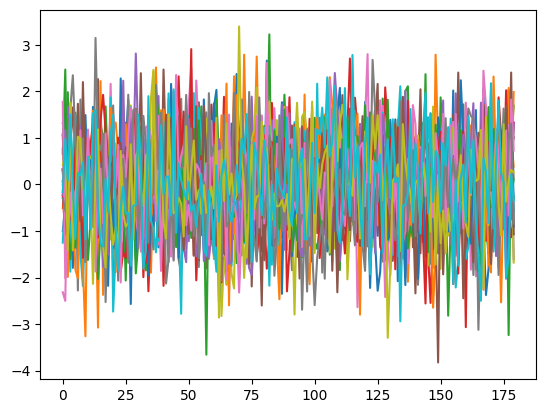

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(xi_samples.T)
plt.show()

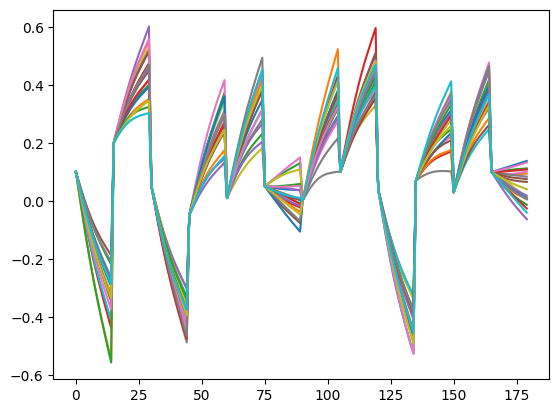

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(thd_all.squeeze(0).T)
plt.show()

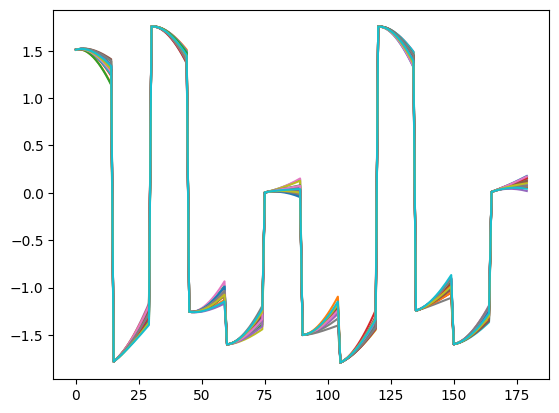

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(th_all.squeeze(0).T)
plt.show()

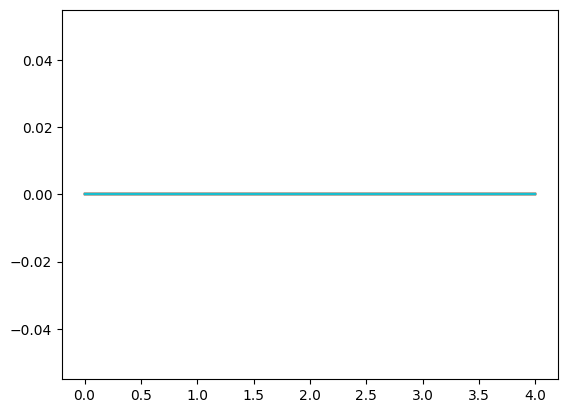

In [18]:
import matplotlib.pyplot as plt
plt.figure()
# plt.plot(primal_residuals[:,idx_min])
plt.plot(primal_residuals)
plt.show()

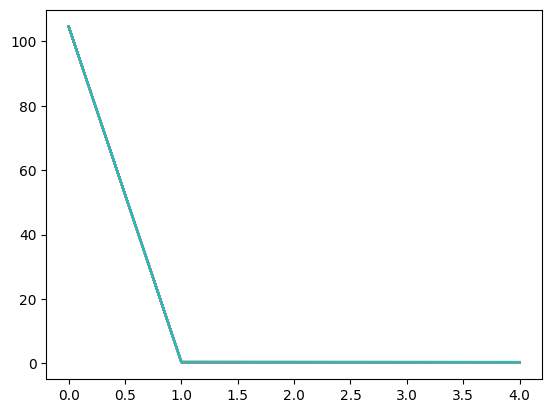

In [19]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fixed_point_residuals)
plt.show()

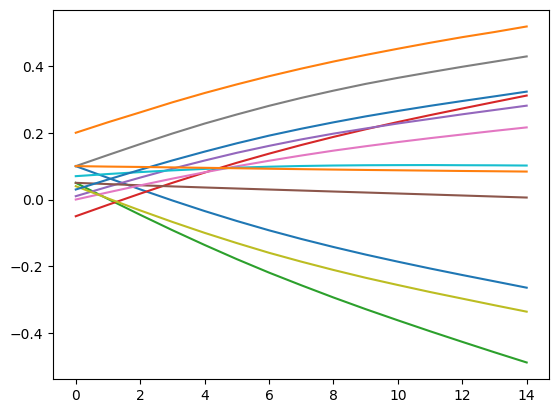

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(best_vels)
plt.show()

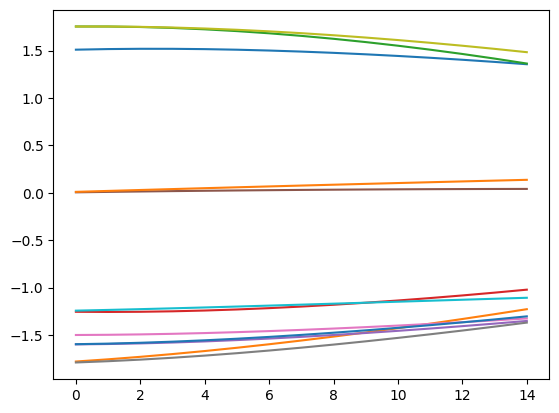

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(best_traj)
plt.show()

In [22]:
import os
import time
import numpy as np
import mujoco
from mujoco import viewer
DOF = num_dof

joint_names_pos = list()
joint_names_vel = list()
for i in range(model.njnt):
        joint_type = model.jnt_type[i]
        n_pos = 7 if joint_type == mujoco.mjtJoint.mjJNT_FREE else 4 if joint_type == mujoco.mjtJoint.mjJNT_BALL else 1
        n_vel = 6 if joint_type == mujoco.mjtJoint.mjJNT_FREE else 3 if joint_type == mujoco.mjtJoint.mjJNT_BALL else 1
        
        for _ in range(n_pos):
            joint_names_pos.append(mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_JOINT, i))
        for _ in range(n_vel):
            joint_names_vel.append(mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_JOINT, i))

robot_joints = np.array(['shoulder_pan_joint_1', 'shoulder_lift_joint_1', 'elbow_joint_1', 'wrist_1_joint_1', 'wrist_2_joint_1', 'wrist_3_joint_1',
                                'shoulder_pan_joint_2', 'shoulder_lift_joint_2', 'elbow_joint_2', 'wrist_1_joint_2', 'wrist_2_joint_2', 'wrist_3_joint_2'])

joint_mask_pos = np.isin(joint_names_pos, robot_joints)
joint_mask_vel = np.isin(joint_names_vel, robot_joints)


In [24]:

class Visualizer:
    def __init__(self, thetadot: np.ndarray):
        """
        thetadot: shape (T, DOF) or (T, N) joint velocities over time
        """
        # self.init_joint_state = cem.init_joint_position

        self.init_joint_state = jnp.array([1.5, -1.8, 1.75, -1.25, -1.6, 0, -1.5, -1.8, 1.75, -1.25, -1.6, 0])

        cem.joint_mask_pos

        # Load model
        # model_path = f"{os.path.dirname(__file__)}/ur5e_hande_mjx/scene.xml"
        model_path = "../ur5e_hande_mjx/scene.xml"
        self.model = mujoco.MjModel.from_xml_path(model_path)
        self.model.opt.timestep = 0.1
        self.data = mujoco.MjData(self.model)

        # Set initial joint state
        self.data.qpos[:DOF] = self.init_joint_state

        # Store trajectory
        self.thetadot = thetadot


    def render_trace(self, viewer_, eef_0=None, eef_1=None, eef_0_=None, eef_1_=None, eef_0_planned=None, eef_1_planned=None):
        """Render the end-effector trajectory trace in the viewer for all batches.
        Any None inputs will be skipped."""
        # Clear any existing overlay geoms
        viewer_.user_scn.ngeom = 0
        
        # Define colors for each type (RGBA format)
        colors = {
            'eef_0': [1, 0, 0, 0.5],      # Red
            'eef_1': [0, 0, 1, 0.5],      # Blue
            'eef_0_': [0, 1, 0, 0.5],     # Green
            'eef_1_': [0, 1, 0, 0.5],     # Green
            'eef_0_planned': [0, 0, 1, 0.5],  # Blue
            'eef_1_planned': [0, 0, 1, 0.5]   # Blue
        }
        
        # Collect traces (skip if None)
        traces = [
            ('eef_0', eef_0),
            ('eef_1', eef_1),
            ('eef_0_', eef_0_),
            ('eef_1_', eef_1_),
            ('eef_0_planned', eef_0_planned),
            ('eef_1_planned', eef_1_planned)
        ]
        
        for trace_name, trace_data in traces:
            if trace_data is None:
                continue  # skip plotting this trace

            rgba = colors[trace_name]

            if trace_name in ['eef_0_planned', 'eef_1_planned']:
                # Shape: (num_steps, 7)
                positions = trace_data[:, :3]
                for pos in positions:
                    self._add_sphere(viewer_, pos, rgba)
            else:
                # Shape: (1, num_batch, num_steps, 7)
                num_batches = trace_data.shape[1]
                for batch_idx in range(num_batches):
                    positions = trace_data[0, batch_idx, :, :3]
                    for pos in positions:
                        self._add_sphere(viewer_, pos, rgba)

    def _add_sphere(self, viewer_, pos, rgba):
        """Helper method to add a sphere to the viewer scene."""
        geom_id = viewer_.user_scn.ngeom
        if geom_id >= viewer_.user_scn.maxgeom:
            return  # Skip if we've reached the maximum number of geoms

        viewer_.user_scn.ngeom += 1

        mujoco.mjv_initGeom(
            viewer_.user_scn.geoms[geom_id],
            type=mujoco.mjtGeom.mjGEOM_SPHERE,
            size=[0.01, 0.01, 0.01],  # radius 1 cm
            pos=pos,
            mat=np.eye(3).flatten(),
            rgba=rgba
        )
   
    
    
    
    def view_traj(self):
        with viewer.launch_passive(self.model, self.data) as viewer_:
            viewer_.cam.distance = 4
            viewer_.cam.azimuth = 120      # horizontal rotation (deg)
            viewer_.cam.elevation = -45   # vertical tilt (deg)
            viewer_.cam.lookat[:] = [0, 0, 0]  # center of the scene

            # # Create a renderer for screenshots
            # renderer = mujoco.Renderer(self.model, height=600, width=800)
            i = 0

            while viewer_.is_running():
                step_start = time.time()

                # Apply velocity
                self.data.qvel[:DOF] = self.thetadot[i]


                self.data.qpos[joint_mask_pos] = self.init_joint_state

                mujoco.mj_step(self.model, self.data)
                # mujoco.mj_forward(self.model, self.data)
                viewer_.sync()

                # if i == 0:  # first frame only
                #     rgb = renderer.render(self.data)
                #     from PIL import Image
                #     Image.fromarray(rgb).save(f"trajectory_{i:04d}.png")


                # Keep real time
                dt = self.model.opt.timestep - (time.time() - step_start)
                if dt > 0:
                    time.sleep(dt)

                # Loop trajectory
                if i < self.thetadot.shape[0] - 1:
                    i += 1
                else:
                    self.data.qvel[:DOF] = np.zeros(DOF)
                    self.data.qpos[:DOF] = self.init_joint_state
                    i = 0

                # self.render_trace(viewer_, eef_0.squeeze(0), eef_1.squeeze(0), eef_0_planned[:,:3], eef_1_planned[:,:3])
                # self.render_trace(viewer_, eef_0, eef_1, best_trace=(eef_0_planned, eef_1_planned))

                # self.render_trace(viewer_,eef_0, eef_1,best_trace=(eef_0_planned, eef_1_planned),extra_trace=(eef_0_, eef_1_))
                self.render_trace(viewer_, eef_0 = eef_0, eef_1 = eef_1, 
                                  eef_0_ = None, eef_1_ = None, 
                                  eef_0_planned = None, 
                                  eef_1_planned = None)


def main():
    # Example: sinusoidal velocities for 6 joints
    # timesteps = 1000
    # t = np.linspace(0, 10, timesteps)
    # thetadot = np.stack([0.0 * np.sin(t) for _ in range(DOF)], axis=1)

    thetadot = best_vels
    # thetadot = np.mean(thd_all[1:int(num_steps*0.5)], axis=0)

    print(thetadot.shape)

    viz = Visualizer(thetadot)
    viz.view_traj()


if __name__ == "__main__":
    main()


(15, 12)


In [25]:
print(eef_0.shape)
print(eef_1.shape)
print(eef_0_planned.shape)


(1, 20, 15, 7)
(1, 20, 15, 7)
(15, 7)


In [26]:
def set_axes_equal(ax):
    """Make axes of a 3D plot have equal scale."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = x_limits[1] - x_limits[0]
    y_range = y_limits[1] - y_limits[0]
    z_range = z_limits[1] - z_limits[0]
    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range/2, x_middle + max_range/2])
    ax.set_ylim3d([y_middle - max_range/2, y_middle + max_range/2])
    ax.set_zlim3d([z_middle - max_range/2, z_middle + max_range/2])

x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)
x_0_ (15,)
x_1_ (15,)


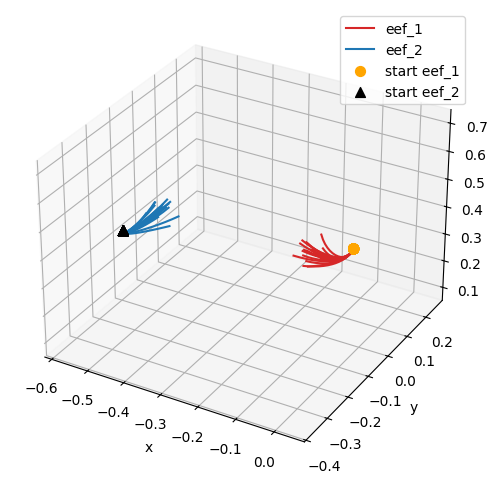

Start points eef_0:
 [[ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]
 [ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]
 [ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]
 [ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]
 [ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]
 [ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]
 [ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]
 [ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]
 [ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]
 [ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]
 [ 0.0333598  -0.10358459  0.49338746  0.08889467  0.7235715   0.67677027
   0.10258698]


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming eef_0_, eef_1_, eef_0, eef_1, xi_cov_single are already defined
arr_0_ = eef_0.squeeze(0)  # shape: (num_batch, num_steps, 3)
arr_1_ = eef_1.squeeze(0)
arr_0 = eef_0.squeeze(0)
arr_1 = eef_1.squeeze(0)

num_batch, num_steps, _ = arr_0_.shape

# 3D Plot of all trajectories
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

color_0 = "tab:red"   # color for all arr_0 trajectories
color_1 = "tab:blue" # color for all arr_1 trajectories

# Plot trajectories
for b in range(num_batch):
    x_0_, y_0_, z_0_ = arr_0_[b, :, 0], arr_0_[b, :, 1], arr_0_[b, :, 2]
    print("x_0_", x_0_.shape)
    x_1_, y_1_, z_1_ = arr_1_[b, :, 0], arr_1_[b, :, 1], arr_1_[b, :, 2]
    print("x_1_", x_1_.shape)
    
    ax.plot(x_0_, y_0_, z_0_, color=color_0, label="eef_1" if b == 0 else "")
    ax.plot(x_1_, y_1_, z_1_, color=color_1, label="eef_2" if b == 0 else "")

# Mark all initial points to check if batches start from same point
ax.scatter(arr_0_[:, 0, 0], arr_0_[:, 0, 1], arr_0_[:, 0, 2],
           color='orange', marker='o', s=50, label="start eef_1")
ax.scatter(arr_1_[:, 0, 0], arr_1_[:, 0, 1], arr_1_[:, 0, 2],
           color='black', marker='^', s=50, label="start eef_2")

# Labels
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()

# Save figure
plt.savefig(f"trajectories_cov_{xi_cov_single[0,0]:.3f}_steps_{num_steps}_batch_{num_batch}.png",
            dpi=300, bbox_inches="tight")
set_axes_equal(ax)
plt.show()

# Optional numeric check for exact values of start points
print("Start points eef_0:\n", arr_0_[:, 0, :])
print("Start points eef_1:\n", arr_1_[:, 0, :])
